In [1]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv(f'data\gibbs_coal.csv', index_col=0)

In [3]:
df.head()

,y
x,
1851,4
1852,5
1853,4
1854,0
1855,1


##### 14.2.1 Visualize data

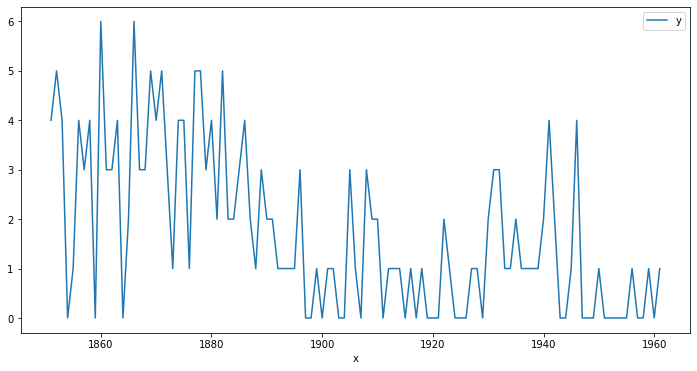

In [4]:
df.plot(figsize=(12,6));

##### 14.2.6 Calculate unnormalized posterior for n

In [5]:
def unnorm_n(n, X, l1, l2):
    N = len(X)
    if n == N-1:
        return 0 # change cannot occur at last point
    
    sum1 = int(np.sum(X[:n]))
    sum2 = int(np.sum(X[n:]))
#     print(sum1, sum2)
#     print(l1**sum1)
#     print(np.exp(-l1 * n))
#     print(l2**sum2)
#     print(np.exp(-l2 * (N-n)))
    return (l1**sum1 * np.exp(-l1 * n)) * (l2**sum2 * np.exp(-l2 * (N-n)))
    

In [6]:
unnorm_n(30, df.y, 3, 1)

9.346474206554585e-28

##### 14.2.7 Calculata normalized posterior for n

In [7]:
def n_distribution(X, l1, l2):
    ns = list(range(len(X)))
    ps = list(map(lambda x: unnorm_n(x, X, l1, l2), ns))
    
    return ns, ps/np.sum(ps)


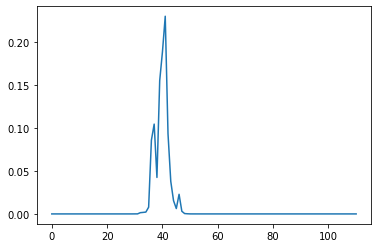

In [8]:
plt.plot(n_distribution(df.y, 3, 1)[1])

##### 14.2.8 Write sampler for n

In [9]:
def sample_n(X, l1, l2, size=None):
    ns, ps = n_distribution(X, l1, l2)
    return np.random.choice(ns, p=ps, size=size)

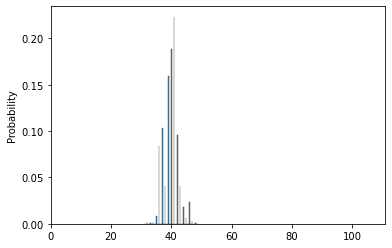

In [10]:
g = sns.histplot(sample_n(df.y, 3, 1, 10000), bins=100, stat='probability').set_xlim(0, df.y.shape[0])

##### 14.2.9 Write samplers for lambdas 

In [11]:
def sample_l1(X, n, a, b):
    return np.random.gamma(a + sum(X[:n]), 1/(b+n), 1)[0]

In [12]:
sample_l1(df.y, 40, 1,1)

2.84114889360368

In [13]:
def sample_l2(X, n, a, b):
    N = len(X)
    return np.random.gamma(a + sum(X[n:]), 1/(b+N-n), 1)[0]

In [14]:
sample_l2(df.y, 40, 1,1)

0.842238459546061

##### 14.2.10 Write complete Gibbs sampler

In [15]:
def get_next_samples(X, a, b, n, l1, l2):
    n_2 = sample_n(X, l1, l2)
    l1_2 = sample_l1(X, n_2, a, b)
    l2_2 = sample_l2(X, n_2, a, b)
    
    return n_2, l1_2, l2_2

In [16]:
def sampler(X, a, b, iters=10000):
    n_0 = np.random.uniform(0, len(X), size=1)[0]
    l1_0, l2_0= np.random.gamma(a, b, size=2)
    
    samples = [(n_0, l1_0, l2_0)]
    
    for i in tqdm(range(iters)):
        new_sample = get_next_samples(X, a, b, *samples[-1])
        samples.append(new_sample)
        
    return list(zip(*samples))

###### Run sampler

In [17]:
ns, l1s, l2s = sampler(df.y, 1, 1, iters=10000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:29<00:00, 66.99it/s]


###### See results

In [18]:
def plot_results(samples, param_name, warmup):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle(param_name)
    data = samples[warmup:]
    ax1.plot(data)
    ax1.set_title('samples chain')
    sns.histplot(data, ax=ax2).set_title('posterior')

In [19]:
warmup = 15

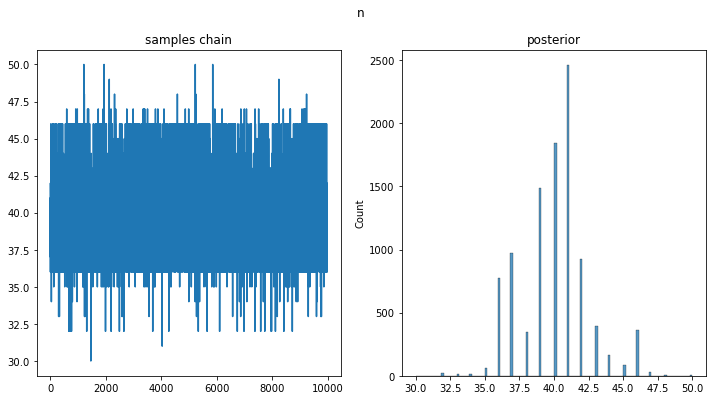

In [20]:
plot_results(ns, 'n', warmup)

###### Estimate 95% CI for n

In [21]:
np.percentile(ns, [2.5, 50, 97.5])

array([36., 40., 46.])

##### 14.2.11 Get posteriors for $lambda_1$ and $lambda_2$

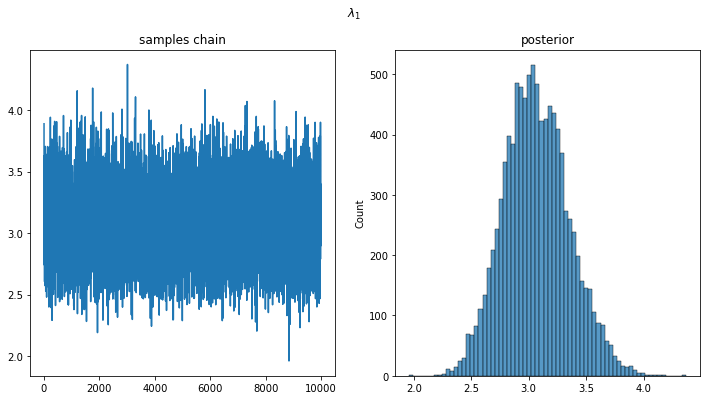

In [22]:
plot_results(l1s, '$\lambda_1$', warmup)

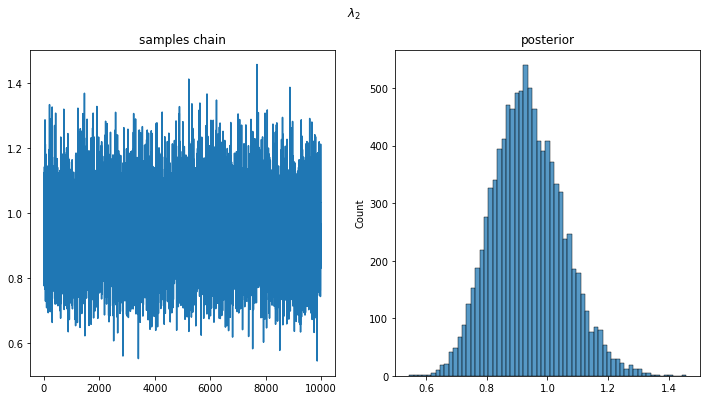

In [23]:
plot_results(l2s, '$\lambda_2$', warmup)

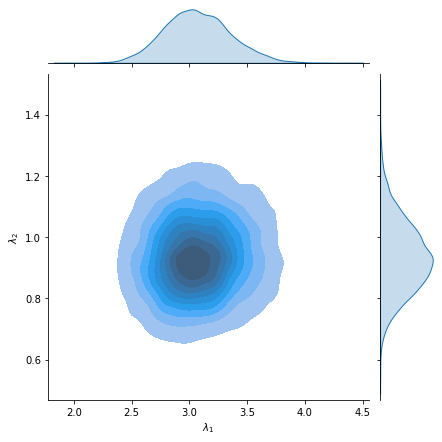

In [24]:
sns.jointplot(x=l1s[warmup:], y=l2s[warmup:], kind='kde', fill=True).set_axis_labels('$\lambda_1$', '$\lambda_2$')

In [25]:
np.median(l1s[warmup:]), np.median(l2s[warmup:])

(3.0546545637633287, 0.9298223594333027)